In [22]:
import numpy as np
from collections import defaultdict

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# Create functions

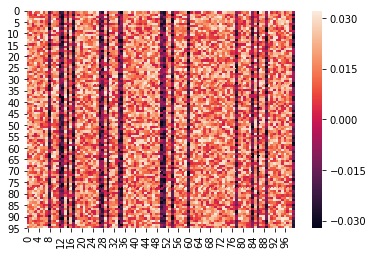

In [194]:
N_NEURONS = 100
W = np.random.rand(N_NEURONS, N_NEURONS)

random_inhib = (np.random.rand(N_NEURONS) <.2)
W[:, random_inhib] = -1* W[:, random_inhib]

ratio = 1 / N_NEURONS / W.mean()
# Tirar conexao com si mesmo
W = ratio * W 

sns.heatmap(W)

In [196]:
omega = np.ones((N_NEURONS, 1)) * 8 / N_NEURONS

In [392]:
class Network(object):
    def __init__(self, 
                 v0, 
                 W, 
                 omega,
                 history_variables=['v', 's']):
        self.v = v0
        self.s = np.zeros_like(v0)
        
        self.W0 = W.copy()
        self.W = W
        self.omega0 = omega.copy()
        self.omega = omega
        self.r = None
        self.s_thalamus = None
        
        self.tau_r = 400
        self.tau_d = 20
        self.leakage = 0.2
        
        self.history_variables = history_variables
        self.history = defaultdict(lambda: [])
        
    def spike(self, v, threshold=1):
        s = (v >= np.random.rand(*v.shape))
        v[s] = 0
        return s, v

    def propagate_spike(self, s):
        nt = self.W @ s
        return nt

    def synapse(self, nt):
        dv = .3 * nt
        return dv

    def external_input(self):
        self.s_thalamus = (np.random.rand(*self.v.shape) < self.r)
        return self.s_thalamus*omega
    
    def plasticity(self):
        self.W = self.W  + (1/self.tau_r) * (self.W0 - self.W) - (1/self.tau_d) * self.W * self.s
        self.omega = self.omega  + (1/self.tau_r) * (self.omega0 - self.omega) - (1/self.tau_d) * self.omega * self.s_thalamus

    def run_simulation(self, r, tmax):
        self.r = r
        for t_i in range(int(tmax/dt)):
            self.s, v = self.spike(self.v)
            nt        = self.propagate_spike(self.s)
            ei        = self.external_input()
            dv        = self.synapse(nt) + ei
            self.v    = v + dv - v * self.leakage
            
            self.append_history()
            self.plasticity()

    def append_history(self):
        for var in self.history_variables:
            self.history[var].append(getattr(self, var))
            
    def get_history(self, attr):
        return np.hstack(self.history[attr])

In [415]:
net = Network(v0=np.zeros((N_NEURONS,1)), 
              W=W,
              omega=omega, 
              history_variables=['v', 's','r', 'W'])

In [416]:
# net.run_simulation(r=0, tmax=100)
# net.run_simulation(r=0.02, tmax=1000)
# net.run_simulation(r=0.1, tmax=2000)
net.run_simulation(r=0.001, tmax=10000)
# net.run_simulation(r=0.1, tmax=2000)

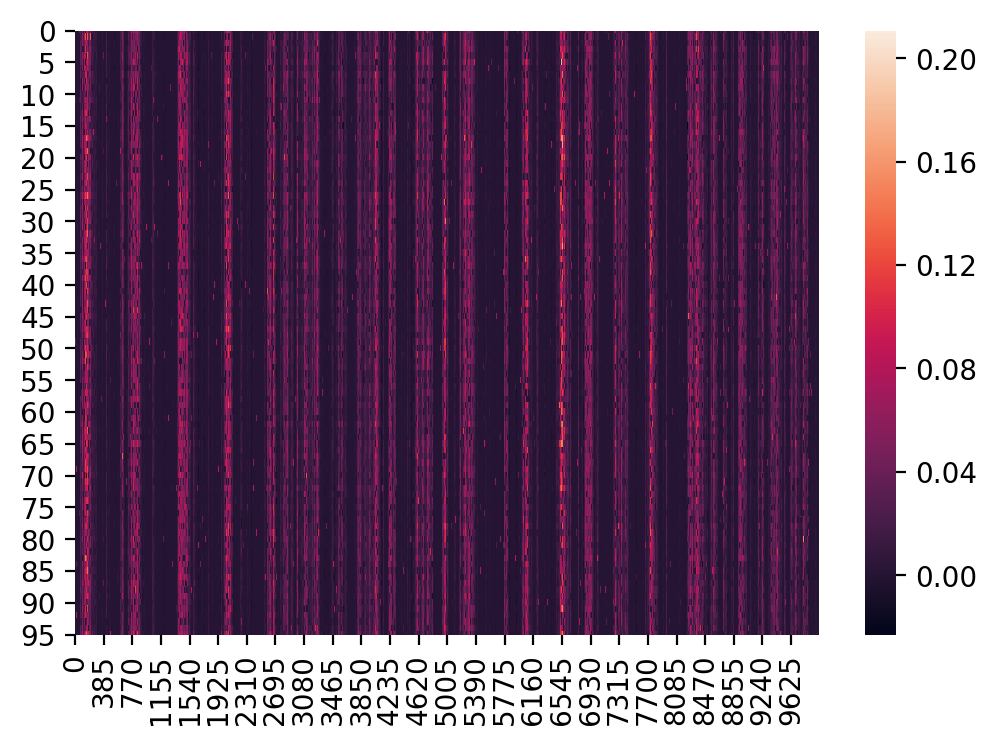

In [417]:
plt.figure(dpi=200)
sns.heatmap(net.get_history('v'))

In [418]:
import ipywidgets as wdg


def plot_raster(trange):
    plt.figure(dpi=200)
    rasterplot(net.get_history('s')[:, trange[0]:trange[1]], 1, t0=trange[0], s=0.01)
    sns.despine(left=True)
    
    
wdg.interact_manual(plot_raster, trange = wdg.IntRangeSlider(min=0, max=10000))

interactive(children=(IntRangeSlider(value=(2500, 7500), description='trange', max=10000), Button(description=…

<function __main__.plot_raster(trange)>

In [420]:
import ipywidgets as wdg


def plot_avg_spk(trange):
    pd.Series(net.get_history('s').sum(axis=0))[trange[0]:trange[1]].plot()
    pd.Series(net.get_history('s').sum(axis=0)).rolling(100).mean(center=True)[trange[0]:trange[1]].plot()
    
    
wdg.interact_manual(plot_avg_spk, trange = wdg.IntRangeSlider(min=0, max=10000))

interactive(children=(IntRangeSlider(value=(2500, 7500), description='trange', max=10000), Button(description=…

<function __main__.plot_avg_spk(trange)>

In [477]:
total_spikes = pd.Series(net.get_history('s').sum(axis=0))
avalanche = total_spikes > 1

In [478]:
event = (avalanche.astype(int).diff().fillna(0)!=0)
event_indexes = event.to_numpy().nonzero()[0]

if len(event_indexes) % 2 == 0:
    avalanche_periods = event_indexes.reshape(-1,2)
else:
    avalanche_periods = event_indexes[:-1].reshape(-1,2)

In [479]:
avalanche_periods

array([[  75,   77],
       [  80,   87],
       [  89,   90],
       ...,
       [9868, 9870],
       [9873, 9874],
       [9965, 9966]])

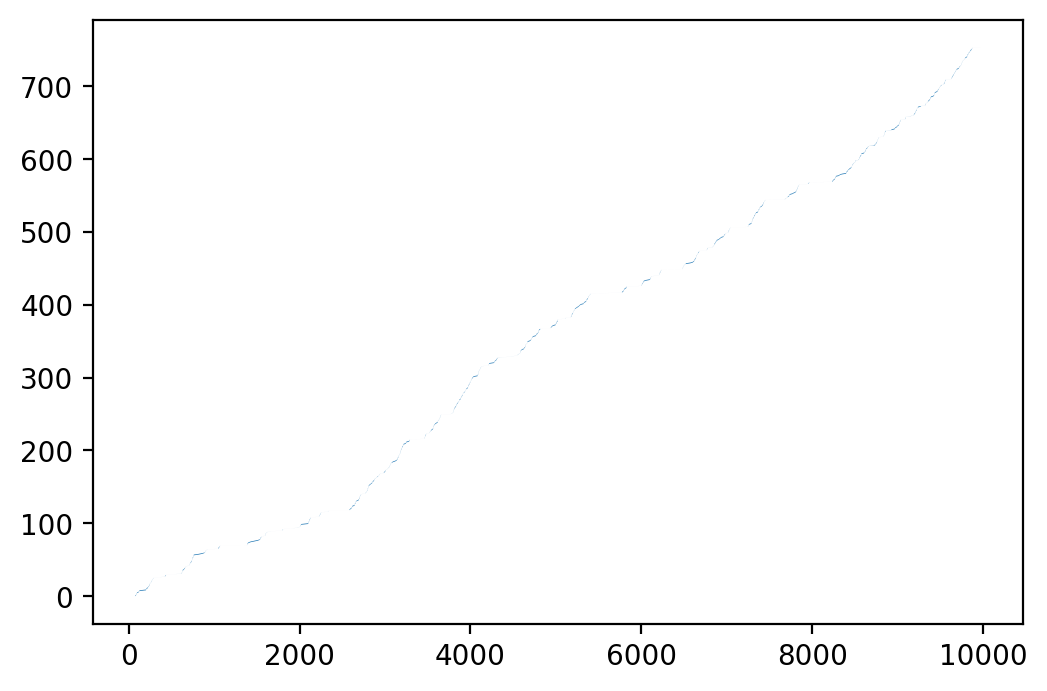

In [537]:
plt.fill_betweenx(np.arange(len(avalanche_periods)), avalanche_periods[:,0], avalanche_periods[:,1])

In [541]:
avalanche_durations = avalanche_periods[:, 1] - avalanche_periods[:, 0]

avalanche_sizes = [net.get_history('s').sum(axis=0)[avalanche_periods[i][0]: avalanche_periods[i][1]].sum()
                    for i in range(len(avalanche_periods))]

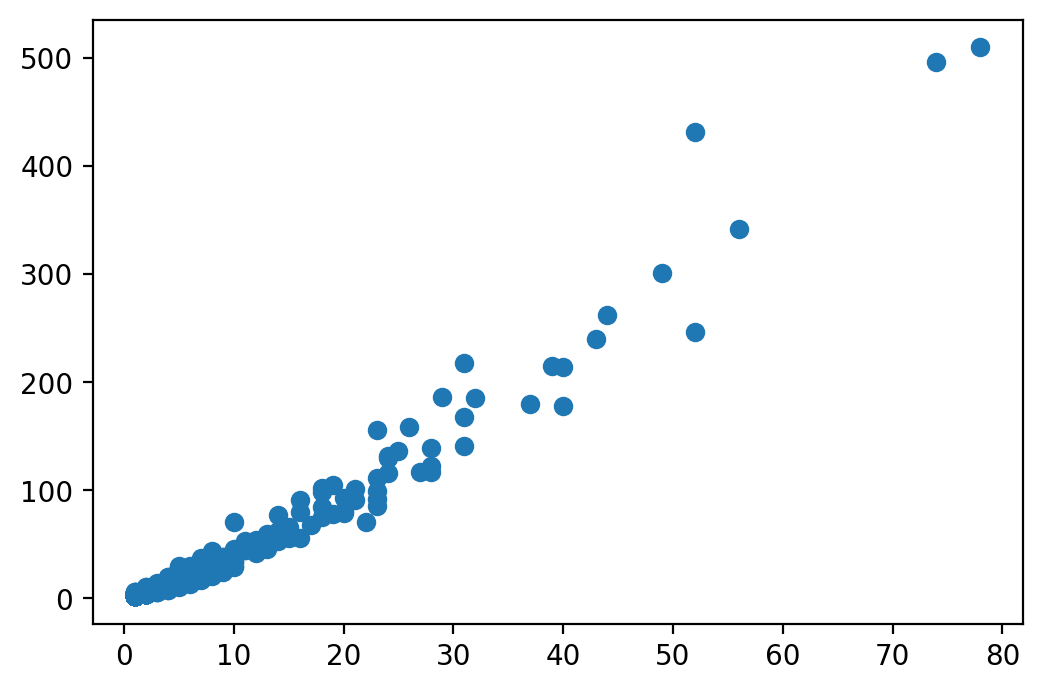

In [542]:
plt.scatter(avalanche_durations, avalanche_sizes)

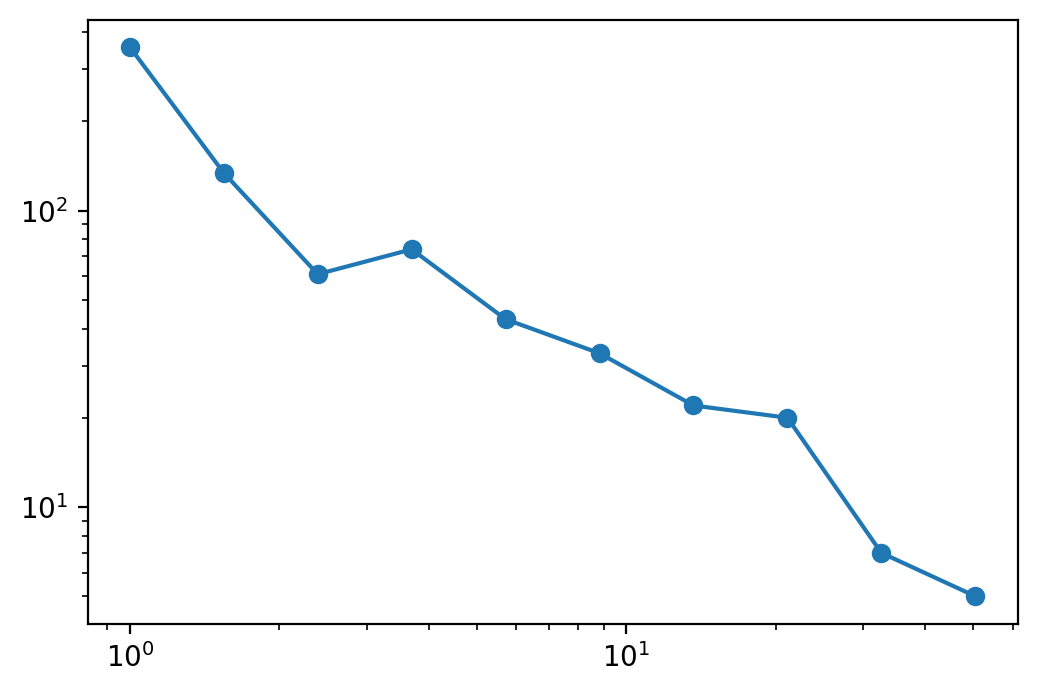

In [543]:
density, bin = np.histogram(np.log10(avalanche_durations), density=False, bins=10)
durations = 10**bin[:-1]

plt.plot(durations, density, marker='o')
plt.yscale('log')
plt.xscale('log')

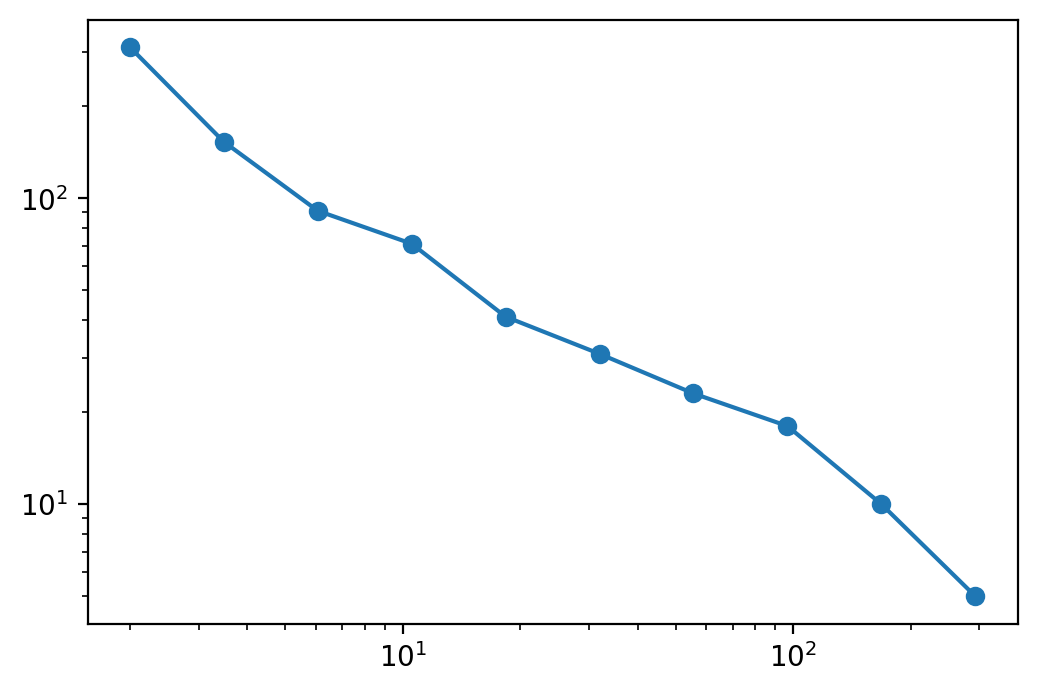

In [544]:
density, bin = np.histogram(np.log10(avalanche_sizes), density=False)
durations = 10**bin[:-1]

plt.plot(durations, density, marker='o')
plt.yscale('log')
plt.xscale('log')

# Test functions

In [56]:
print(spike(v = np.array([0, .5, .9])))
print(spike(v = np.array([0, 1., .9])))
print(spike(v = np.array([0, -1., .9])))

NameError: name 'spike' is not defined

In [57]:
s = np.array([True, False, False]).reshape(3, 1)
print(propagate_spike(s, W))

s = np.array([True, False, True]).reshape(3, 1)
print(propagate_spike(s, W))

[[0]
 [0]
 [1]]
[[2]
 [1]
 [1]]


In [58]:
W@ s

array([[2],
       [1],
       [1]])

In [97]:
np.hstack(net.history['v'])[:10,:100]

array([[0.00880139, 0.01990514, 0.03047598, 0.0410768 , 0.05078959,
        0.06159955, 0.07298556, 0.08206533, 0.09093744, 0.10510159,
        0.11240912, 0.12505526, 0.13543268, 0.14563465, 0.15672707,
        0.16972014, 0.17951622, 0.19227599, 0.20108794, 0.21002906,
        0.22070971, 0.23211827, 0.23855396, 0.24881815, 0.25984261,
        0.26539322, 0.27597941, 0.28557656, 0.29506129, 0.302804  ,
        0.31278906, 0.32233093, 0.33182719, 0.34241316, 0.35216488,
        0.36149565, 0.37356195, 0.3830281 , 0.39428048, 0.40426763,
        0.41373345, 0.42433421, 0.43601232, 0.44668915, 0.45415156,
        0.46157236, 0.46889622, 0.4777307 , 0.48643732, 0.49418983,
        0.50130551, 0.5090965 , 0.52050279, 0.52928065, 0.53701236,
        0.54580882, 0.55382856, 0.56403247, 0.57736644, 0.588825  ,
        0.59667187, 0.60446869, 0.61616305, 0.62539652, 0.63955462,
        0.65125259, 0.66268625, 0.67001843, 0.68324557, 0.69260154,
        0.70403647, 0.71507361, 0.72583013, 0.73

# Visuals

In [379]:
def rasterplot(spike_history, dt, t0=0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    n, t = np.nonzero(spike_history)
    ax.scatter(t, n, color='k', **kwargs)
    ax.set_yticks([])
    ax.set_xlim(0, spike_history.shape[1])
    
    xticks = ax.get_xticks()
    ax.set_xticklabels((xticks*dt + t0).astype(int))
    return ax

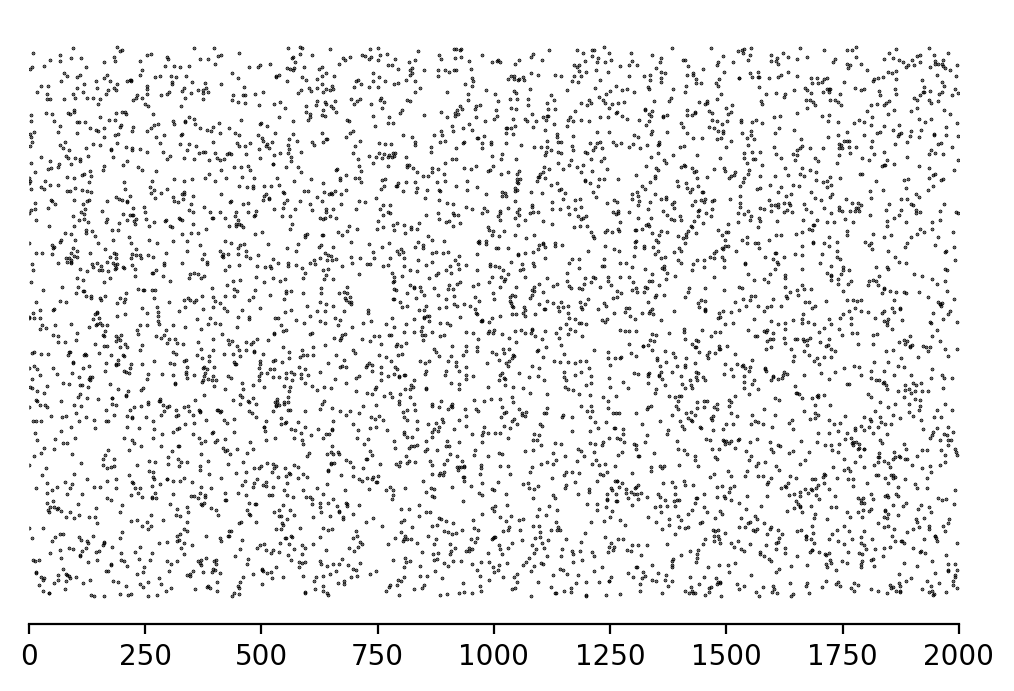

In [380]:
spike_history = (np.random.rand(500,2000) > .995).astype(int) # Random "s"
rasterplot(spike_history, 1, s=.1)
sns.despine(left=True)